In [223]:
import geopandas as gpd
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import folium

In [120]:
# Prevent warning messages from openpyxl
# Courtesy of https://stackoverflow.com/a/66015981/4361039

import warnings
warnings.simplefilter("ignore")

In [121]:
# Function to read census tract boundaries geopackage file
# Returns a geodataframe
def read_tracts(year):
    geo = gpd.read_file(
        f'./census-tracts/{year}-toronto-ct.gpkg'
    )
    
    # Identify column with census tract names
    ct_col_name = [ col for col in geo.columns if str(col).lower()[:2] == 'ct' ][0]
    
    # Only return two columns: ct, geometry
    geo = geo.filter([ct_col_name, 'geometry'])
    geo.columns = ['ct', 'geometry']
    
    # Make sure census tract names are strings, not ints
    geo.ct = geo.ct.apply(str)
    
    return geo


# Function to read a single year of Census data from Excel
# Returns a dataframe
def read_data(year):
    
    dfs = pd.read_excel(
        f'./census-data/QC Completed {year}.xlsx',
        sheet_name=None,        # read all available sheets
        na_values=['no data']
    )
    
    # Sheets that contain census tract data are named "CT Tab..."
    data_tab_names = [ tab for tab in dfs if tab.startswith('CT Tab') ]
    
    print(f"Census {year}: reading data from {', '.join(data_tab_names)}")
    
    # Combine data across tabs into a single df
    data = pd.concat( [ dfs[tab] for tab in data_tab_names ] )
    
    # Lowercase column names
    data.columns = [ str(x).lower() for x in data.columns ]
    data = data.rename(columns={
        'ct name': 'ct'
    })
    
    # Make sure census tracts are strings, not ints
    data.ct = data.ct.apply(str)
    
    return data


# Reads a single year of census
# Returns a geodataframe
def read_census(year):
    
    data = read_data(year)
    geo = read_tracts(year)
    
    return geo.merge(data, how='right', on='ct')

## Read all Census years

In [122]:
c1951 = read_census(1951)
c1961 = read_census(1961)
c1971 = read_census(1971)
c1981 = read_census(1981)
c1991 = read_census(1991)
c2001 = read_census(2001)
c2011 = read_census(2011)

Census 1951: reading data from CT Tab-Etobicoke Twshp, CT Tab-Long Branch, CT Tab-New Toronto, CT Tab-Mimico
Census 1961: reading data from CT Tab - Etobicoke Twshp, CT Tab - Long Branch, CT Tab - New Toronto, CT Tab - Mimico
Census 1971: reading data from CT Tab - Borough of Etobicoke
Census 1981: reading data from CT Tab - Borough of Etobicoke
Census 1991: reading data from CT Tab - City of Etobicoke
Census 2001: reading data from CT Tab - F-Etobicoke
Census 2011: reading data from CT Tabs F-Etobicoke


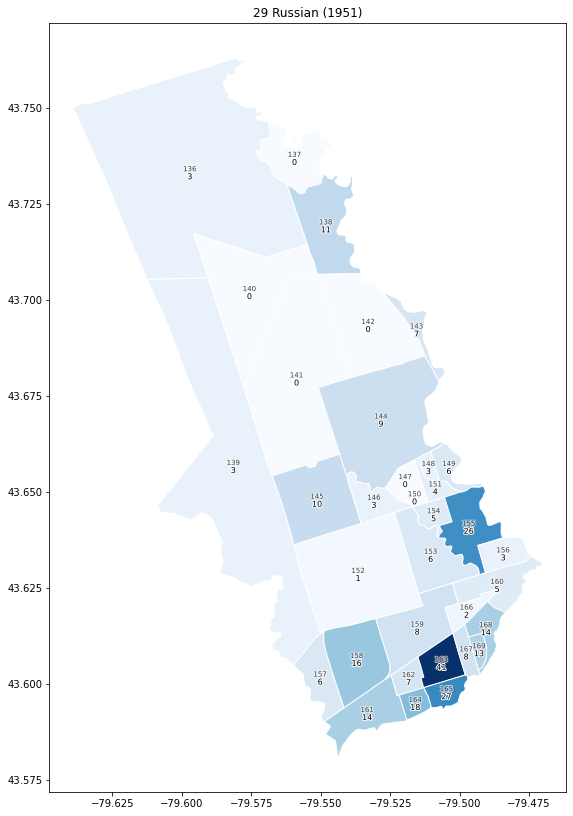

In [232]:
field = '29 russian'

ax = c1951.plot(
    column=field,
    cmap='Blues',
    edgecolor='white',
    legend=False,
    figsize=(10,14.14)
)

ax.set_title(f"{field.title()} (1951)")

for i, row in c1951.iterrows():
    
    x = row.geometry.centroid.x
    y = row.geometry.centroid.y
    
    ax.annotate(
        row.ct,
        xy=(x, y),
        xytext=(0,0),
        textcoords="offset points",
        ha='center',
        va='bottom',
        alpha=0.5,
        path_effects=[pe.Stroke(linewidth=2, foreground='w'), pe.Normal()],
        fontsize=7
    )
    
    ax.annotate(
        row[field],
        xy=(x, y),
        xytext=(0,0),
        textcoords="offset points",
        ha='center',
        va='top',
        alpha=1,
        fontsize=8,
        path_effects=[pe.Stroke(linewidth=2, foreground='w'), pe.Normal()],
        color='black'
    )

In [235]:
ax.get_figure().savefig('test.pdf', dpi=300)